In [1]:
import numpy as np, matplotlib.pyplot as plt
H, W = 800, 1600
img = np.ones((H, W, 3), float)
def add_band(y0, y1, color):
    y = np.linspace(0, H-1, H)
    mask = (y[:, None] >= y0) & (y[:, None] <= y1)
    blur = np.exp(-((y[:, None] - (y0+y1)/2)/(0.12*(y1-y0)))**2)
    for c in range(3):
        img[..., c] = np.where(mask, color[c]/255.0*blur + (1-blur)*img[..., c], img[..., c])

add_band(int(0.22*H), int(0.35*H), (220, 60, 60))   # red
add_band(int(0.45*H), int(0.58*H), (60, 180, 75))   # green
add_band(int(0.68*H), int(0.81*H), (60, 120, 220))  # blue


plt.imsave("init_image.png", np.clip(img,0,1))
"init_image.png"

'init_image.png'

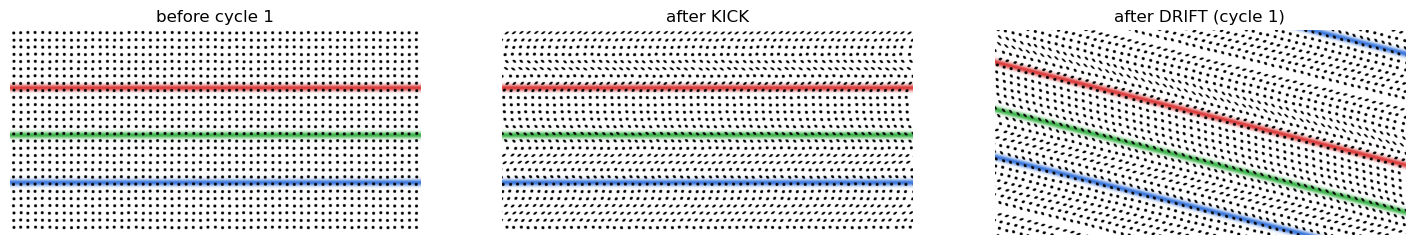

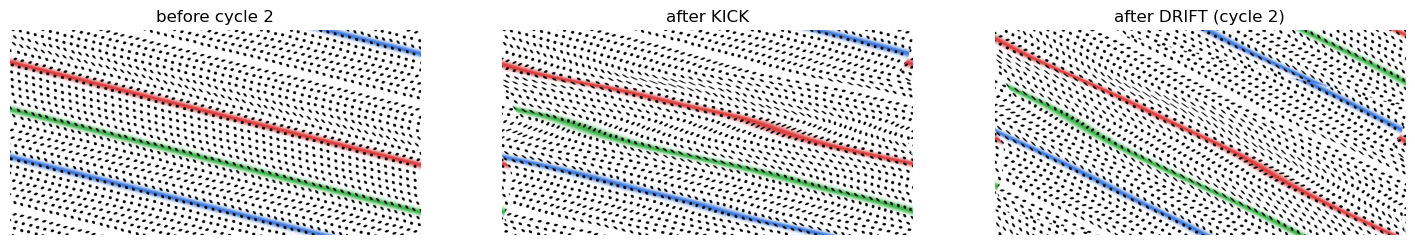

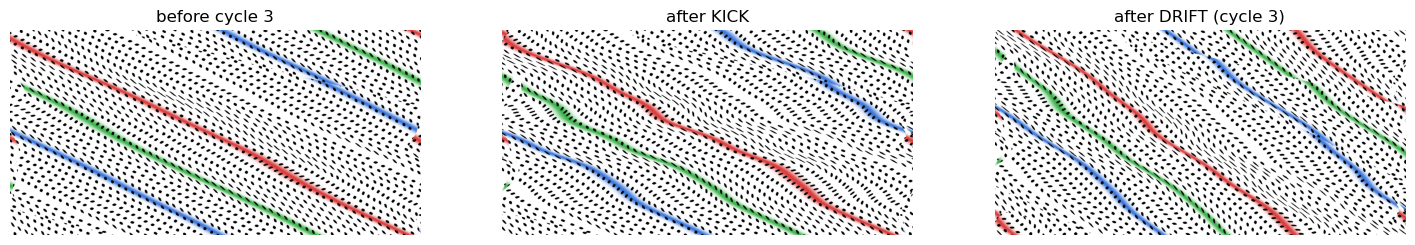

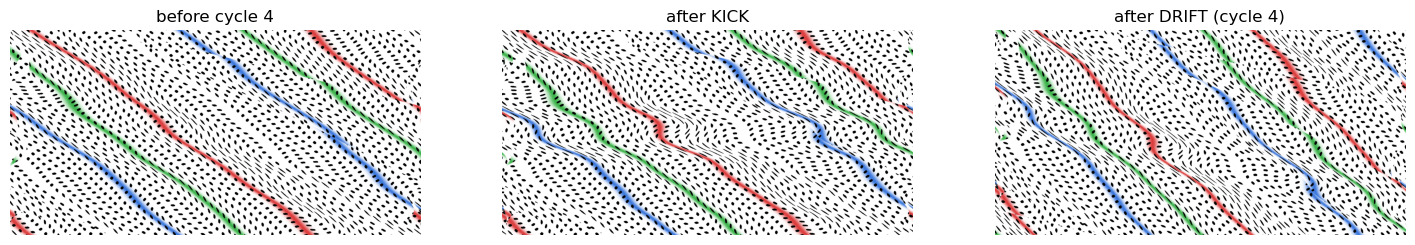

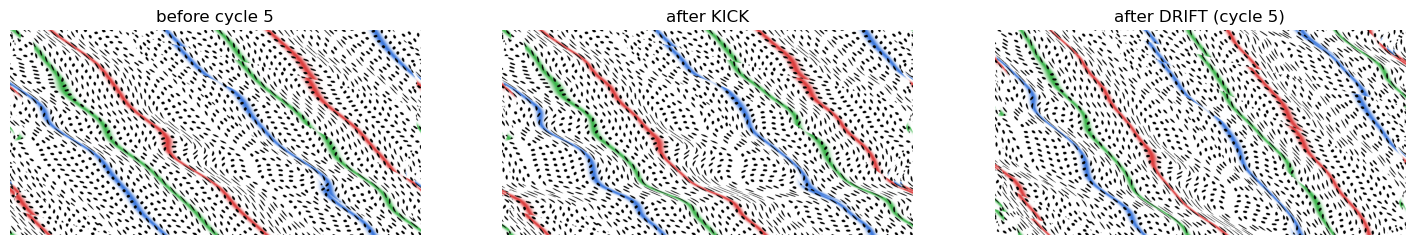

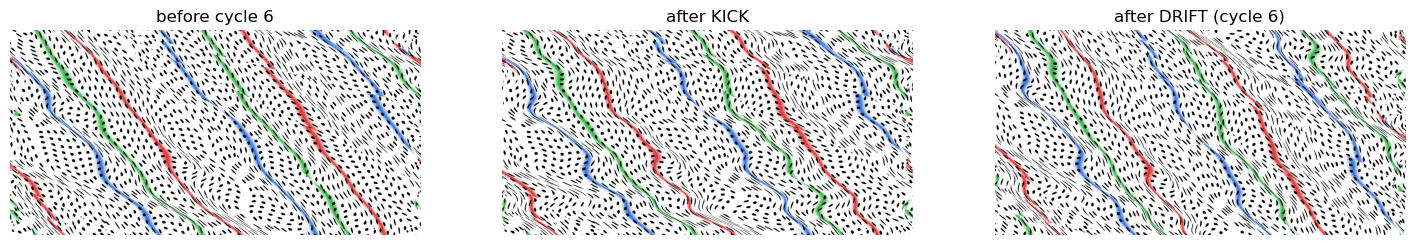

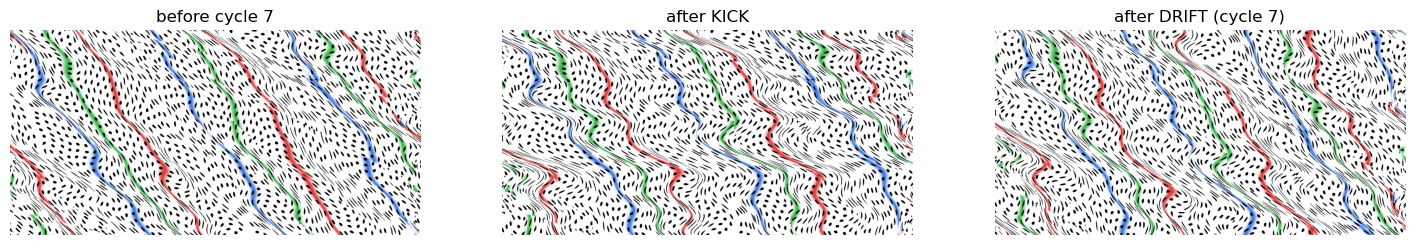

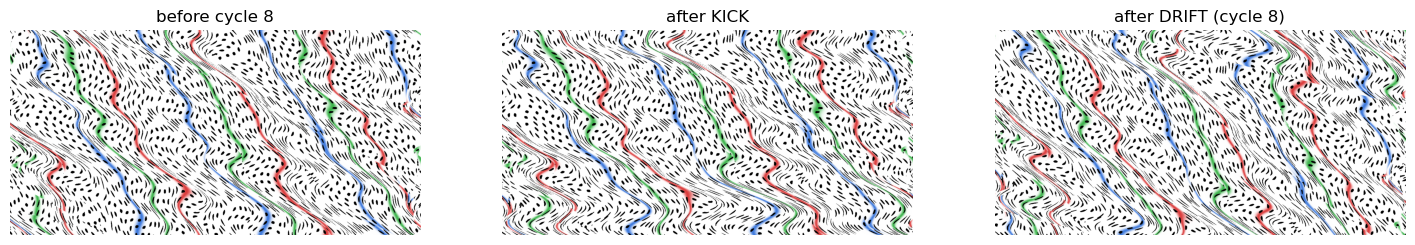

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp
from skimage.io import imread
from skimage.draw import disk
from skimage.measure import label, regionprops
from skimage.morphology import dilation, closing, disk as se_disk  

rng = np.random.default_rng(0)
def randpot1d_getFFT(c):
    f = np.fft.fft(np.fft.ifftshift(c))
    return np.sqrt(np.abs(f)).astype(np.complex128)
def randpot1d_four(cf, rng=rng):
    n = cf.shape[0]
    p = (2*rng.random(n//2-1)-1)*np.pi
    phase = np.zeros(n)
    phase[1:n//2] = p
    phase[n//2+1:] = -p[::-1]
    cff = cf * np.exp(1j*phase)
    cff[0] = 0
    u = np.sqrt(n) * np.fft.ifft(cff)
    u = np.real(u)
    return u / (np.std(u) + 1e-12)
def InverseKick(coords, dp_x):
    R = np.asarray(coords)           
    x = R[:, 1]
    n = dp_x.shape[0]
    x0 = np.floor(x)
    i  = (x0.astype(int)) % n
    dpy = dp_x[i] + (dp_x[(i+1) % n] - dp_x[i]) * (x - x0)
    Rp = R.copy()
    Rp[:, 0] = Rp[:, 0] - dpy        # vertical-only displacement
    return Rp
def InverseDrift(coords, row0, Tau):
    R = np.asarray(coords)
    Rp = R.copy()
    Rp[:, 1] = Rp[:, 1] - (Rp[:, 0] - row0) * Tau  
    return Rp
def forward_map(y, x, dp_x, row0, Tau, rows, cols):
    n  = dp_x.shape[0]
    x0 = np.floor(x)
    i  = int(x0) % n
    dpy = dp_x[i] + (dp_x[(i+1) % n] - dp_x[i]) * (x - x0)
    y1 = (y - dpy) % rows
    x1 = (x + (y1 - row0) * Tau) % cols
    return y1, x1
def sigma_max_from_dp_slope(g, Tau):
    smax = np.empty_like(g, dtype=float)
    for k, gi in enumerate(np.atleast_1d(g)):
        F = np.array([[1.0, -gi], [Tau, 1.0 - Tau*gi]], dtype=float)
        smax[k] = np.linalg.svd(F, compute_uv=False)[0]
    return smax

cycles = 8
image = imread("init_image.png").astype(float)/255.0
if image.ndim == 2: image = np.dstack([image, image, image])
if image.shape[2] == 4: image = image[:, :, :3]
rows, cols = image.shape[:2]
if rows % 2: image = image[1:,:,:]
if cols % 2: image = image[:,1:,:]
rows, cols = image.shape[:2]

row0 = rows/2.0
lc   = 0.045
K0   = 0.035
Tau0 = 0.5
Lx = 1.0; Lp = 1.0
K   = K0/float(Lp)*rows
Tau = float(Tau0*Lx*rows)/(cols*Lp)
xgrid = np.linspace(-Lx/2, Lx/2, cols, endpoint=True)
c_x   = np.exp(-xgrid**2 / lc**2)
cf_x  = randpot1d_getFFT(c_x)
pitch_y, pitch_x = 28, 28
margin = 14
R = 6  # dot radius

ys = np.arange(margin, rows - margin, pitch_y)
xs = np.arange(margin, cols - margin, pitch_x)
Y, X = np.meshgrid(ys, xs, indexing='ij')
centers = np.column_stack([Y.ravel(), X.ravel()])   # [y, x]
jitter = rng.integers(-1, 2, size=centers.shape)
centers = np.clip(centers + jitter, [0,0], [rows-1, cols-1]).astype(float)
M = centers.shape[0]
dots = np.zeros((rows, cols), float)
for (yy, xx) in centers.astype(int):
    rr, cc = disk((yy, xx), R, shape=dots.shape)
    dots[rr, cc] = 1.0

ftle_sum = np.zeros(M, float)
q_stable = 5           # % lowest FTLE called "stable" per iteration
R_island = 12          
morph_merge = False    

centers_hist      = []   # list of (M,2)
ftle_avg_hist     = []   # list of (M,)
stable_idx_hist   = []   # list of index arrays
island_count_hist = []   # list[int]
island_area_hist  = []   # list[np.ndarray]
cur = image.copy()
cur_dots = dots.copy()
x_densities = []   

for it in range(cycles):
    dp_x = K * randpot1d_four(cf_x, rng=rng)
    stage1_img  = warp(cur,      InverseKick, map_args={'dp_x': dp_x}, mode='wrap', order=1, preserve_range=True)
    stage1_dots = warp(cur_dots, InverseKick, map_args={'dp_x': dp_x},mode='wrap', order=1, preserve_range=True)
    stage2_img  = warp(stage1_img,  InverseDrift, map_args={'row0': row0, 'Tau': Tau}, mode='wrap', order=1, preserve_range=True)
    stage2_dots = warp(stage1_dots, InverseDrift, map_args={'row0': row0, 'Tau': Tau}, mode='wrap', order=1, preserve_range=True)
    idx = (np.floor(centers[:,1]).astype(int)) % cols
    g   = (dp_x[(idx + 1) % cols] - dp_x[idx])          
    smax_vec = sigma_max_from_dp_slope(g, Tau)
    ftle_sum += np.log(np.clip(smax_vec, 1e-12, None))
    for j in range(M):
        y1, x1 = forward_map(centers[j,0], centers[j,1], dp_x, row0, Tau, rows, cols)
        centers[j] = (y1, x1)
    gimg = 0.2126*stage2_img[...,0] + 0.7152*stage2_img[...,1] + 0.0722*stage2_img[...,2]
    x_densities.append(gimg.mean(axis=0))
    ftle_avg_now = ftle_sum / float(it + 1)
    ftle_avg_hist.append(ftle_avg_now.copy())
    centers_hist.append(centers.copy())
    thr_it = np.percentile(ftle_avg_now, q_stable)
    stable_mask_it = ftle_avg_now <= thr_it
    stable_idx_it  = np.nonzero(stable_mask_it)[0]
    stable_idx_hist.append(stable_idx_it)
    mask_it = np.zeros((rows, cols), dtype=bool)
    
    for j in stable_idx_it:
        y, x = centers[j]
        rr, cc = disk((int(y), int(x)), R_island, shape=mask_it.shape)
        mask_it[rr, cc] = True
    if morph_merge:
        mask_it = dilation(mask_it, se_disk(2))
        mask_it = closing(mask_it,  se_disk(3))
    lab_it = label(mask_it, connectivity=1)
    props_it = [p for p in regionprops(lab_it) if p.area >= 15]
    areas_it = np.array([p.area for p in props_it], dtype=float) if props_it else np.array([], float)
    island_count_hist.append(len(props_it))
    island_area_hist.append(areas_it)
    
    def overlay(img_rgb, dots_gray):
        out = img_rgb.copy()
        if out.shape[2] == 4: out = out[:, :, :3]
        out[dots_gray > 0.4] = 0.0
        return out

    f, (p1, p2, p3) = plt.subplots(1, 3, figsize=(18,6), sharey=True)
    for ax in (p1,p2,p3):
        ax.axis('off'); ax.set_aspect('equal')
    p1.imshow(overlay(cur,      cur_dots));   p1.set_title(f'before cycle {it+1}')
    p2.imshow(overlay(stage1_img, stage1_dots)); p2.set_title('after KICK')
    p3.imshow(overlay(stage2_img, stage2_dots)); p3.set_title(f'after DRIFT (cycle {it+1})')
    plt.show()

    cur, cur_dots = stage2_img, stage2_dots

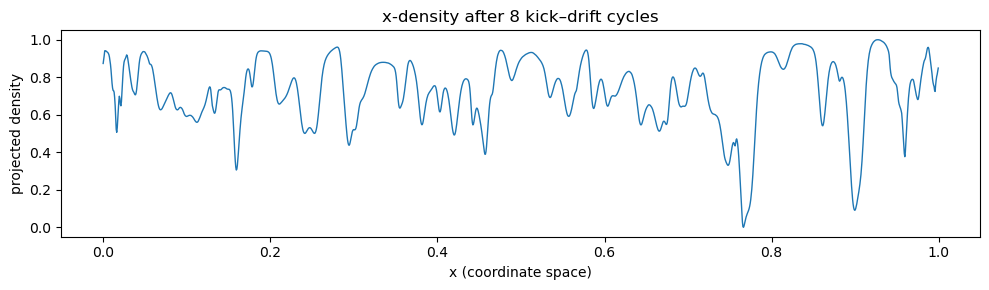

In [3]:
import numpy as np
import matplotlib.pyplot as plt
rows, cols = cur.shape[:2]
gray = 0.2126*cur[...,0] + 0.7152*cur[...,1] + 0.0722*cur[...,2]
x_density = gray.mean(axis=0)          
x_density = (x_density - x_density.min()) / (x_density.ptp() + 1e-12)
x = np.linspace(0.0, 1.0, cols, endpoint=False)

plt.figure(figsize=(10,3))
plt.plot(x, x_density, lw=1)
plt.xlabel("x (coordinate space)")
plt.ylabel("projected density")
plt.title(f"x-density after {cycles} kick–drift cycles")
plt.tight_layout()
plt.show()

# (optional) save to file
plt.figure(figsize=(10,3))
plt.plot(x, x_density, lw=1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("x_density_projection.png", dpi=150, bbox_inches="tight")
plt.close()

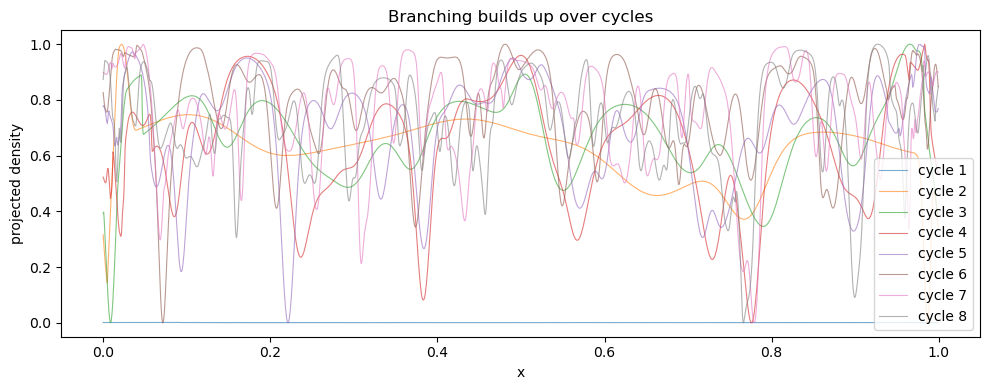

In [4]:
plt.figure(figsize=(10,4))
for k, xd in enumerate(x_densities):
    xd = (xd - xd.min())/(xd.ptp()+1e-12)
    plt.plot(np.linspace(0,1,len(xd),endpoint=False), xd, lw=0.8, alpha=0.6, label=f"cycle {k+1}")
plt.legend()
plt.xlabel("x")
plt.ylabel("projected density")
plt.title("Branching builds up over cycles")
plt.tight_layout()
plt.show()

FTLE threshold (q=5%): 0.161
Stable centers: 80 / 1596


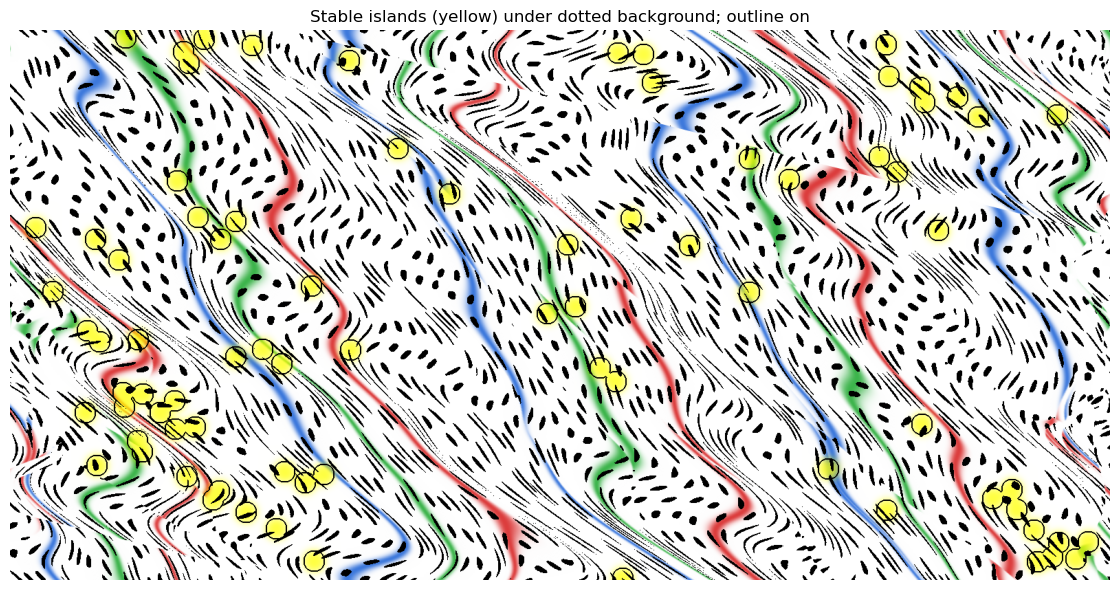

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from skimage.filters import gaussian
from skimage.morphology import binary_erosion, disk as se_disk
T = cycles
ftle_avg = ftle_sum / T
q = 5                         
thr = np.percentile(ftle_avg, q)
stable_mask = ftle_avg <= thr
stable_idx  = np.nonzero(stable_mask)[0]

print(f"FTLE threshold (q={q}%): {thr:.3f}")
print(f"Stable centers: {stable_mask.sum()} / {len(ftle_avg)}")

base = cur.copy()
if base.ndim == 2: base = np.dstack([base, base, base])
if base.shape[2] == 4: base = base[:, :, :3]
H, W = base.shape[:2]
R_blob   = 16        # radius in pixels for the yellow islands 
alpha_y  = 0.75      # yellow opacity 
edge_px  = 2         # black outline thickness in pixels; 0 disables outline
softness = 0.35      # Gaussian softness as fraction of radius (0.25–0.45 looks nice)

mask = np.zeros((H, W), dtype=bool)
for j in stable_idx:
    y, x = centers[j]
    rr, cc = disk((int(y), int(x)), R_blob, shape=mask.shape)
    mask[rr, cc] = True
alpha = gaussian(mask.astype(float), sigma=R_blob*softness, preserve_range=True)
alpha = np.clip(alpha, 0, 1) * alpha_y  
yellow = np.array([1.0, 1.0, 0.0], dtype=float)
base = (1 - alpha[..., None]) * base + alpha[..., None] * yellow

if edge_px > 0:
    edge = mask & ~binary_erosion(mask, se_disk(edge_px))
    base[edge] = [0, 0, 0]
dots_mask = cur_dots > 0.4
base[dots_mask] = [0, 0, 0]

plt.figure(figsize=(12, 6))
plt.imshow(base)
plt.axis('off')
plt.title("Stable islands (yellow) under dotted background; outline on")
plt.tight_layout(); plt.show()


Stable islands (connected components): 80
Area stats (px): min=82.0, median=109.0, max=109.0


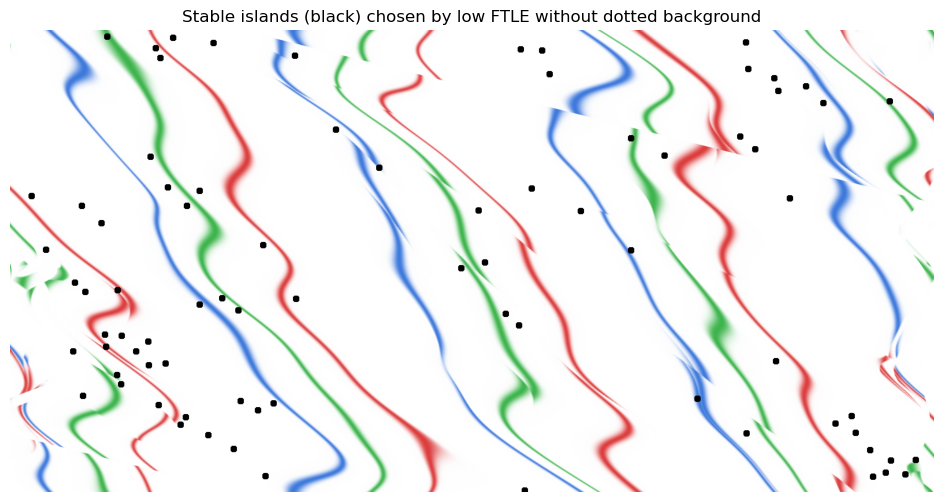

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from skimage.measure import label, regionprops
try:
    stable_idx
except NameError:
    T = cycles
    ftle_avg = ftle_sum / T
    q = 5
    thr = np.percentile(ftle_avg, q)
    stable_idx  = np.nonzero(ftle_avg <= thr)[0]
mask = np.zeros_like(cur_dots, dtype=bool)
R_vis = 6  
for j in stable_idx:
    y, x = centers[j]
    rr, cc = disk((int(y), int(x)), R_vis, shape=mask.shape)
    mask[rr, cc] = True

lab = label(mask, connectivity=1)
props = [p for p in regionprops(lab) if p.area >= 15]  # drop tiny specks
areas = [p.area for p in props]
print(f"Stable islands (connected components): {len(props)}")
if areas:
    print(f"Area stats (px): min={np.min(areas)}, median={np.median(areas)}, max={np.max(areas)}")

overlay = cur.copy()
if overlay.ndim == 2: overlay = np.dstack([overlay]*3)
if overlay.shape[2] == 4: overlay = overlay[:, :, :3]
#overlay[cur_dots > 0.4] = [196,164,132]   # keep the black dotted background
overlay[mask] = [0,0,0]             # stable islands appear as black clusters
plt.figure(figsize=(12,6))
plt.imshow(overlay)
plt.axis('off')
plt.title("Stable islands (black) chosen by low FTLE without dotted background")
plt.show()


N_stable = 80, lambda = 6.250e-05 points/pixel^2
Dispersion index D = var/mean = 1.08  (≈1 uniform Poisson; >1 clustered, <1 over-regular)
r_nn mean = 50.03 px, median = 37.91 px
Poisson E[r_nn] ≈ 63.25 px  (observed/expected = 0.79)


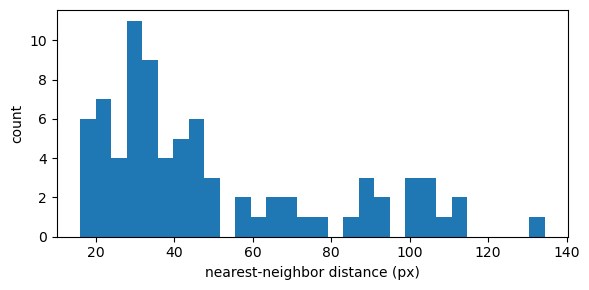

In [7]:
import numpy as np
import matplotlib.pyplot as plt
try:
    stable_idx
except NameError:
    T = cycles
    ftle_avg = ftle_sum / T
    q = 5
    thr = np.percentile(ftle_avg, q)
    stable_idx = np.nonzero(ftle_avg <= thr)[0]

pts = centers[stable_idx].astype(np.float64, copy=False)  # (N,2) [y,x], ensure float
N = len(pts)
H, W = cur.shape[:2]
area = float(H * W)
lam = N / area  # points per pixel^2

print(f"N_stable = {N}, lambda = {lam:.3e} points/pixel^2")
bins_y, bins_x = 20, 40
counts, _, _ = np.histogram2d(pts[:,0], pts[:,1], bins=[bins_y, bins_x], range=[[0, H], [0, W]])
mu = counts.mean()
var = counts.var(ddof=1)
D = var / (mu + 1e-12)
print(f"Dispersion index D = var/mean = {D:.2f}  (≈1 uniform Poisson; >1 clustered, <1 over-regular)")

if N > 1 and N <= 5000:
    dy = np.abs(pts[:, None, 0] - pts[None, :, 0])
    dy = np.minimum(dy, H - dy)
    dx = np.abs(pts[:, None, 1] - pts[None, :, 1])
    dx = np.minimum(dx, W - dx)
    d2 = dx*dx + dy*dy
    np.fill_diagonal(d2, np.inf)
    rnn = np.sqrt(d2.min(axis=1))
    print(f"r_nn mean = {rnn.mean():.2f} px, median = {np.median(rnn):.2f} px")
    rnn_poisson = 1.0 / (2.0 * np.sqrt(lam + 1e-12))
    print(f"Poisson E[r_nn] ≈ {rnn_poisson:.2f} px  (observed/expected = {rnn.mean()/rnn_poisson:.2f})")

    plt.figure(figsize=(6,3))
    plt.hist(rnn, bins=30)
    plt.xlabel("nearest-neighbor distance (px)")
    plt.ylabel("count")
    plt.tight_layout(); plt.show()
else:
    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(pts)
        dists, idxs = tree.query(pts, k=2)  
        rnn = dists[:, 1]
        rnn_poisson = 1.0 / (2.0 * np.sqrt(lam + 1e-12))
        print(f"[KDTree] r_nn mean = {rnn.mean():.2f} px, median = {np.median(rnn):.2f} px")
        print(f"[KDTree] Poisson E[r_nn] ≈ {rnn_poisson:.2f} px  "
              f"(observed/expected = {rnn.mean()/rnn_poisson:.2f})")
    except Exception as e:
        print("Nearest-neighbor check skipped (too many points for O(N^2) and SciPy not available).", e)


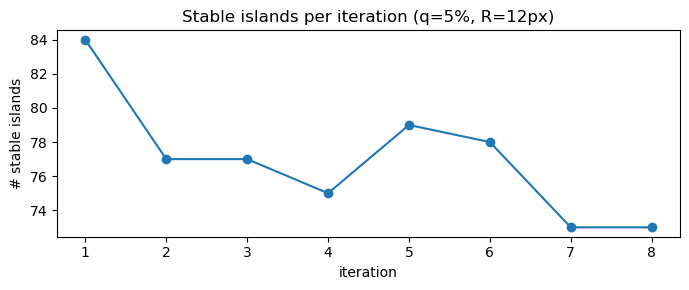

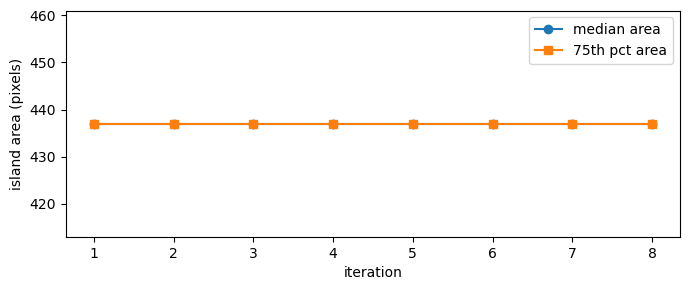

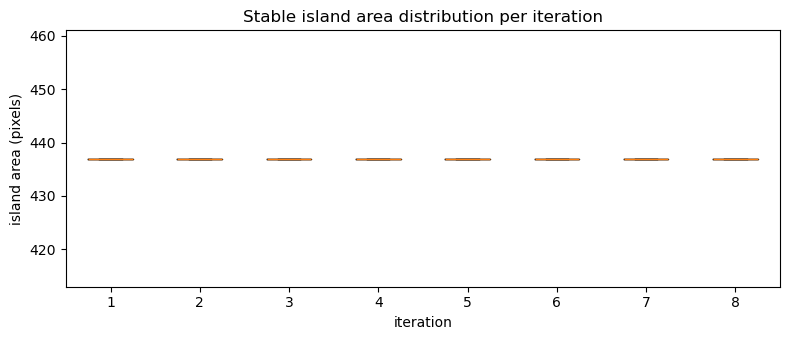

In [8]:
import numpy as np
import matplotlib.pyplot as plt
iters = np.arange(1, len(island_count_hist) + 1)

# A) Number of islands vs iteration
plt.figure(figsize=(7,3))
plt.plot(iters, island_count_hist, marker='o')
plt.xlabel("iteration")
plt.ylabel("# stable islands")
plt.title(f"Stable islands per iteration (q={q_stable}%, R={R_island}px)")
plt.tight_layout(); plt.show()

# Size statistics vs iteration (median & 75th percentile)
med = [np.median(a) if len(a) else 0 for a in island_area_hist]
p75 = [np.percentile(a, 75) if len(a) else 0 for a in island_area_hist]

plt.figure(figsize=(7,3))
plt.plot(iters, med, marker='o', label='median area')
plt.plot(iters, p75, marker='s', label='75th pct area')
plt.xlabel("iteration"); plt.ylabel("island area (pixels)")
plt.legend(); plt.tight_layout(); plt.show()

# C) Optional: boxplot of areas across iterations
plt.figure(figsize=(max(8, len(island_area_hist)*0.6), 3.5))
plt.boxplot([a if len(a) else np.array([0]) for a in island_area_hist],
            labels=[str(i) for i in iters], showfliers=False)
plt.xlabel("iteration"); plt.ylabel("island area (pixels)")
plt.title("Stable island area distribution per iteration")
plt.tight_layout(); plt.show()
